<a href="https://colab.research.google.com/github/tianyuenyt/MO-PCDE_M9_final_assignment/blob/main/Slot_Usage_Peak_vs_Vally_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
#@title **Load Compute Data**
#@markdown 👈 **Click this Play button** to start.
#@markdown

#@markdown - If no **Date Range** is entered, the query will **automatically load data from the last two quarters**.
#@markdown - You can refine your results by entering a **custom Date Range** below.


from google.colab import auth
import pandas as pd
from google.cloud import bigquery
from datetime import datetime, timedelta
from google.colab import files
import ipywidgets as widgets

# Authenticate Google Cloud
auth.authenticate_user()

# Specify GCP project ID
project_id ="nyt-platform-analytics-dbt"
client = bigquery.Client(project=project_id)

# Function to get default date range
def get_default_date_range():
    today = datetime.today()
    current_quarter_month = 3 * ((today.month - 1) // 3) + 1
    first_day_of_this_quarter = datetime(today.year, current_quarter_month, 1)

    if first_day_of_this_quarter.month == 1:
        first_day_of_last_quarter = datetime(today.year - 1, 10, 1)
    else:
        first_day_of_last_quarter = datetime(today.year, current_quarter_month - 3, 1)

    yesterday = today - timedelta(days=1)
    return first_day_of_last_quarter.strftime('%Y-%m-%d'), yesterday.strftime('%Y-%m-%d')

# User input for date range
start_date_input = input("Enter start date (YYYY-MM-DD) or press Enter to use default (first day of last quarter): ").strip()
end_date_input = input("Enter end date (YYYY-MM-DD) or press Enter to use default (yesterday): ").strip()
project_id_input = input("Enter a Project ID to filter (or press Enter to include all): ").strip()
reservation_name_input = input("Enter a Reservation Name to filter (or press Enter to include all): ").strip()

# Assign defaults if needed
default_start, default_end = get_default_date_range()
start_date = start_date_input if start_date_input else default_start
end_date = end_date_input if end_date_input else default_end

# Validate input dates
try:
    start_date_dt = datetime.strptime(start_date, "%Y-%m-%d")
    end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")
    today_dt = datetime.today()

    if end_date_dt < start_date_dt:
        raise ValueError("Error: The end date cannot be earlier than the start date.")
    if end_date_dt > today_dt:
        raise ValueError("Error: The end date cannot be later than today.")
except ValueError as e:
    raise ValueError(f"Invalid date input: {e}")

reservation_filter = ""
if reservation_name_input:
    reservation_filter = (
        "AND (CASE "
        "WHEN reservation_id LIKE '%.%' THEN SPLIT(reservation_id, '.')[OFFSET(1)] "
        "ELSE reservation_id END) = "
        f"'{reservation_name_input}'"
    )

# Define SQL query
billing_query = f"""
WITH base AS (
  SELECT
    DATE(start_time, 'America/New_York') AS start_date,
    DATETIME(start_time, 'America/New_York') AS start_time,
    project_id,
    CASE
      WHEN reservation_id LIKE '%.%' THEN SPLIT(reservation_id, '.')[OFFSET(1)]
      ELSE reservation_id
    END AS reservation_name,
    user_email,
    job_id,
    job_type,
    statement_type,
    total_slot_ms,
    total_bytes_billed
  FROM `nyt-platform-analytics-dbt.prod.stg_bq__jobs_by_organization`
  WHERE 1=1
    AND _pt BETWEEN '{start_date}' AND '{end_date}'
    {f"AND project_id = '{project_id_input}'" if project_id_input else ""}
    {reservation_filter}
),

processed AS (
  SELECT
    reservation_name,
    start_date,
    EXTRACT(YEAR FROM start_time) AS year,
    EXTRACT(WEEK FROM start_time) AS week_of_year,
    EXTRACT(DAYOFWEEK FROM start_time) AS day_of_week,
    CASE
      WHEN EXTRACT(DAYOFWEEK FROM start_time) BETWEEN 2 AND 6 THEN False
      ELSE True
    END AS is_weekend,
    ((EXTRACT(DAYOFWEEK FROM start_time) - 1) * 24 + CAST(FORMAT_TIMESTAMP('%H', start_time) AS INT64) + 1) AS hour_of_week,
    -- FORMAT_TIMESTAMP('%H:%M', start_time) AS hour_minute,
    CAST(FORMAT_TIMESTAMP('%H', start_time) AS INT64) AS hour,
    CAST(FORMAT_TIMESTAMP('%M', start_time) AS INT64) AS minute,
    total_slot_ms
  FROM base
  WHERE 1=1
    AND reservation_name IS NOT NULL
    AND FORMAT_TIMESTAMP('%H', start_time) IS NOT NULL
    AND FORMAT_TIMESTAMP('%M', start_time) IS NOT NULL
),

hourly_data AS (
  SELECT
    start_date,
    is_weekend,
    hour_of_week,
    hour,
    SUM(total_slot_ms) AS total_slot_ms,
    SUM(total_slot_ms / 1000 / 60 / 60) AS total_slot_hr
  FROM processed
  GROUP BY ALL
)

SELECT *
FROM hourly_data
"""

# ANSI Color Code
RED = "\033[31m"
GREEN = "\033[32m"
YELLOW = "\033[33m"
BOLD = "\033[1m"
RESET = "\033[0m"


try:
    df = client.query(billing_query).to_dataframe()
    print(f"{GREEN}{BOLD} Your BigQuery Compute data from {start_date} to {end_date} is ready!{RESET}")
except Exception as e:
    error_message = str(e).lower()

    if "permission" in error_message or "access denied" in error_message:
        print(f"{RED}{BOLD} Query failed due to a permission issue: {e}{RESET}")
        print(f"{YELLOW}{BOLD} Please contact the Platform Analytics Team for access.{RESET}")
    else:
        print(f"{RED}{BOLD} Query failed: {e}{RESET}")

download_button = widgets.Button(description="💾 Download as Excel")

def download_compute_data(change):
    filename = f"bq_slot_usage_{start_date}_to_{end_date}.xlsx"
    df.to_excel(filename, index=False)
    print(f"\n✅ File saved: {filename}")
    files.download(filename)

download_button.on_click(download_compute_data)
display(download_button)


Enter start date (YYYY-MM-DD) or press Enter to use default (first day of last quarter): 
Enter end date (YYYY-MM-DD) or press Enter to use default (yesterday): 
Enter a Project ID to filter (or press Enter to include all): 
Enter a Reservation Name to filter (or press Enter to include all): 
 Your BigQuery Compute data from 2025-01-01 to 2025-04-15 is ready!


Button(description='💾 Download as Excel', style=ButtonStyle())


✅ File saved: bq_slot_usage_2025-01-01_to_2025-04-15.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
#@title **Data Preprocessing**
#@markdown 👈 **Click this Play button** to start.
#@markdown

import pandas as pd

summary_by_hour = df.groupby('hour').agg(
    hour_count=('start_date', 'count'),
    avg_slot_adjusted=('total_slot_hr', 'mean'),
    max_slot=('total_slot_hr', 'max'),
    min_slot=('total_slot_hr', 'min'),
    median_slot=('total_slot_hr', 'median')
).reset_index()


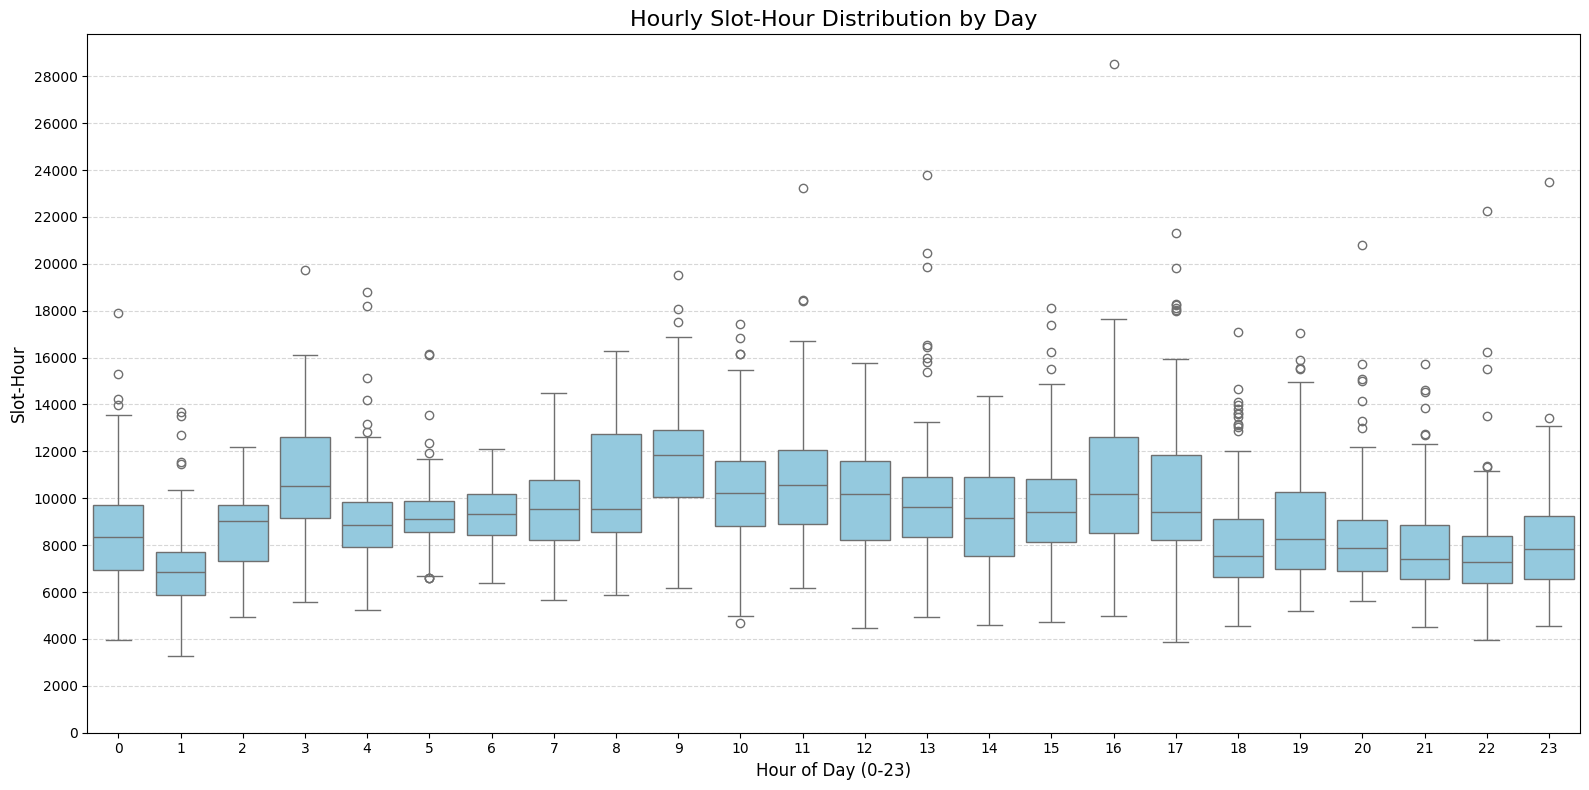

In [25]:
#@title **Visualization I - Boxplot**
#@markdown 👈 **Click this Play button** to start.
#@markdown

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 8))
sns.boxplot(data=df, x='hour', y='total_slot_hr', color='skyblue')

plt.title('Hourly Slot-Hour Distribution by Day', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Slot-Hour', fontsize=12)

# Add more y-axis ticks
plt.yticks(np.arange(0, 30000, 2000))  # You can adjust this interval as needed

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


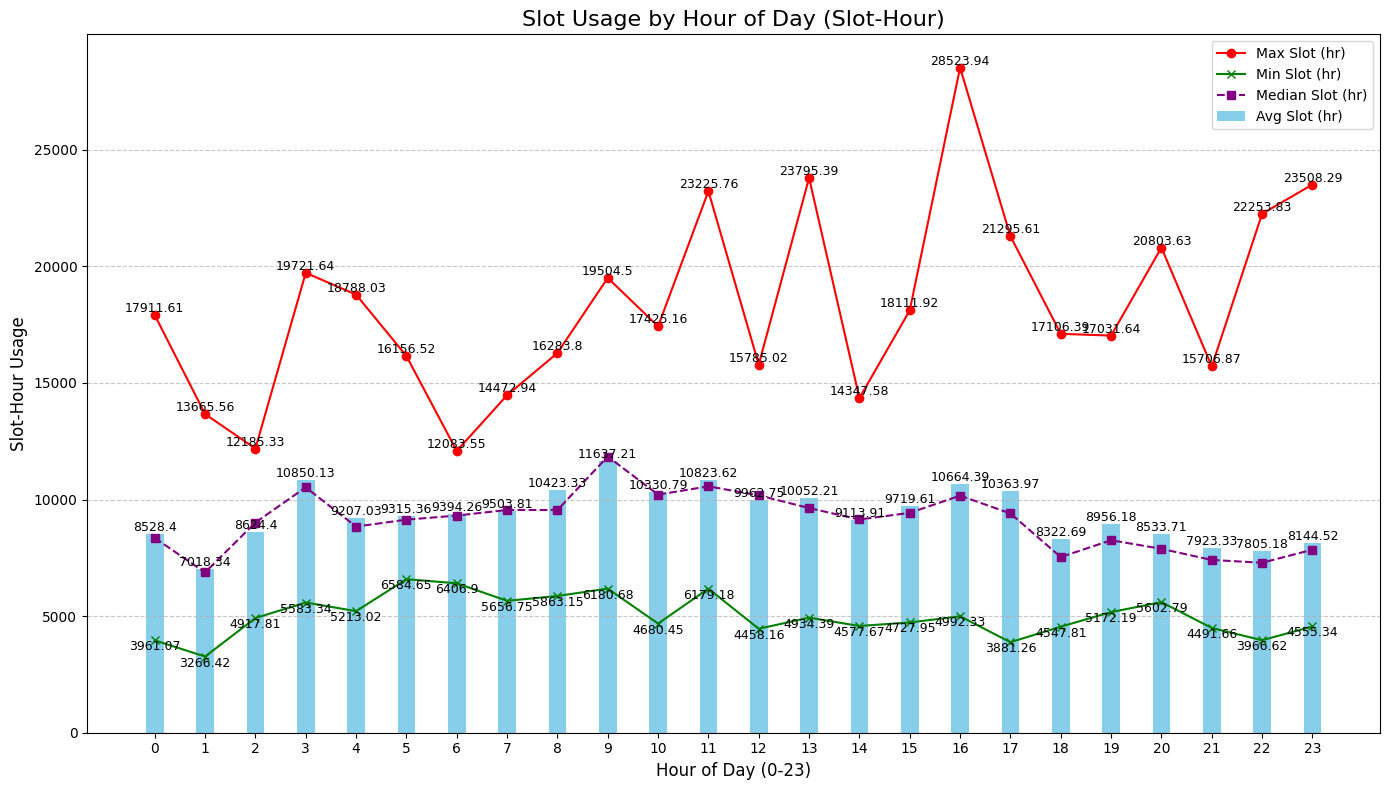

In [26]:
#@title **Visualization II - Peak & Vally Overview**
#@markdown 👈 **Click this Play button** to start.
#@markdown

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure you already have summary_by_hour calculated
# summary_by_hour = df.groupby(...) ... [already done]

# Start plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Bar chart for average slot usage
bar_width = 0.35
hours = summary_by_hour['hour']
r1 = np.arange(len(hours))

# Bar: Average Slot Usage
ax.bar(r1, summary_by_hour['avg_slot_adjusted'], color='skyblue', width=bar_width, label='Avg Slot (hr)')

# Line plots: max, min, median slot usage
ax.plot(r1, summary_by_hour['max_slot'], label='Max Slot (hr)', color='red', marker='o')
ax.plot(r1, summary_by_hour['min_slot'], label='Min Slot (hr)', color='green', marker='x')
ax.plot(r1, summary_by_hour['median_slot'], label='Median Slot (hr)', color='purple', linestyle='--', marker='s')

# Annotate values
for i in range(len(summary_by_hour)):
    ax.annotate(round(summary_by_hour['avg_slot_adjusted'][i], 2), (r1[i], summary_by_hour['avg_slot_adjusted'][i]), ha='center', va='bottom', fontsize=9)
    ax.annotate(round(summary_by_hour['max_slot'][i], 2), (r1[i], summary_by_hour['max_slot'][i]), ha='center', va='bottom', fontsize=9)
    ax.annotate(round(summary_by_hour['min_slot'][i], 2), (r1[i], summary_by_hour['min_slot'][i]), ha='center', va='top', fontsize=9)

# Titles and labels
ax.set_title('Slot Usage by Hour of Day (Slot-Hour)', fontsize=16)
ax.set_xlabel('Hour of Day (0-23)', fontsize=12)
ax.set_ylabel('Slot-Hour Usage', fontsize=12)
ax.set_xticks(r1)
ax.set_xticklabels(summary_by_hour['hour'])

ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Optional save
plt.savefig('slot_usage_by_hour.png')
plt.show()



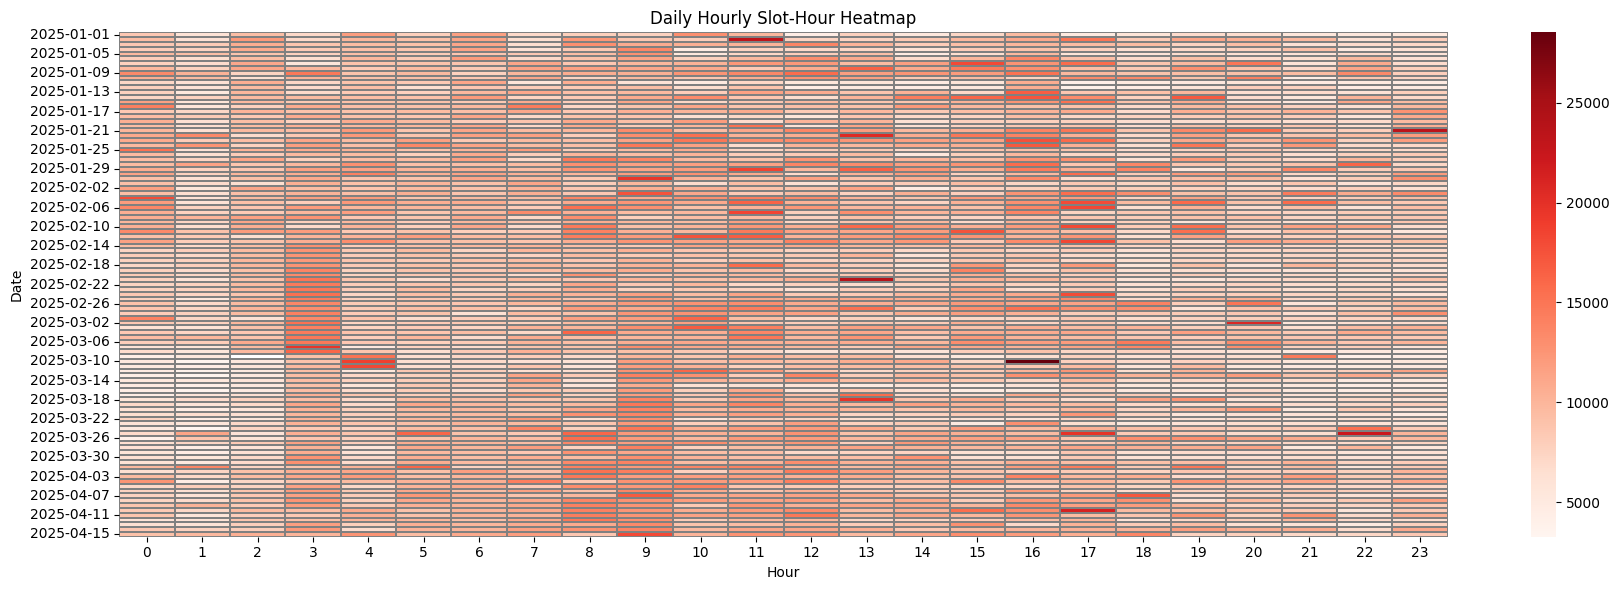

In [6]:
#@title **Visualization III - Heatmap**
#@markdown 👈 **Click this Play button** to start.
#@markdown

pivot = df.pivot(index='start_date', columns='hour', values='total_slot_hr')
plt.figure(figsize=(18, 6))
sns.heatmap(
    pivot,
    cmap='Reds',
    linewidths=0.3,
    linecolor='gray'
)
plt.title('Daily Hourly Slot-Hour Heatmap')
plt.xlabel('Hour')
plt.ylabel('Date')
plt.tight_layout()
plt.show()


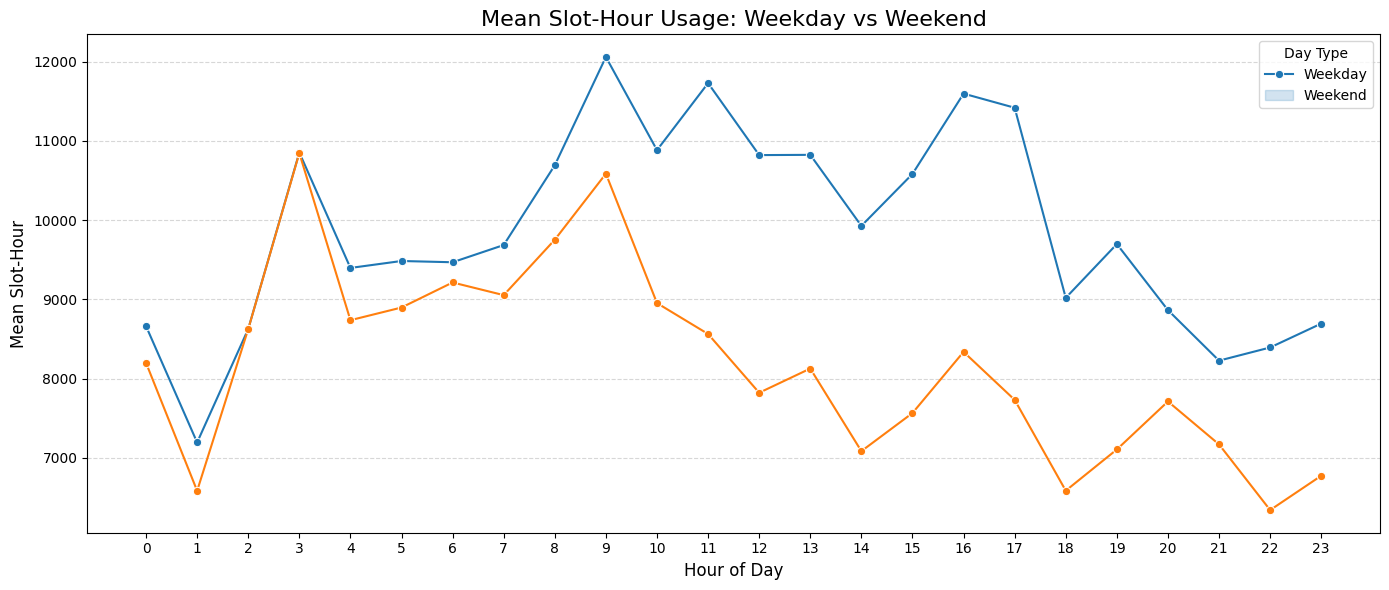

In [7]:
#@title **Visualization IV - Weekday vs Weekend**
#@markdown 👈 **Click this Play button** to start.
#@markdown
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

df['start_date'] = pd.to_datetime(df['start_date'])

# 1. Weekday vs Weekend
df['weekday'] = df['start_date'].dt.weekday  # Monday=0, Sunday=6
df['is_weekend'] = df['weekday'].isin([5, 6])
weekday_vs_weekend = df.groupby(['is_weekend', 'hour'])['total_slot_hr'].agg(['median', 'mean', 'max', 'min', 'count']).reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=weekday_vs_weekend, x='hour', y='mean', hue='is_weekend', marker='o')
plt.title('Mean Slot-Hour Usage: Weekday vs Weekend', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Mean Slot-Hour', fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.legend(title='Day Type', labels=['Weekday', 'Weekend'])
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


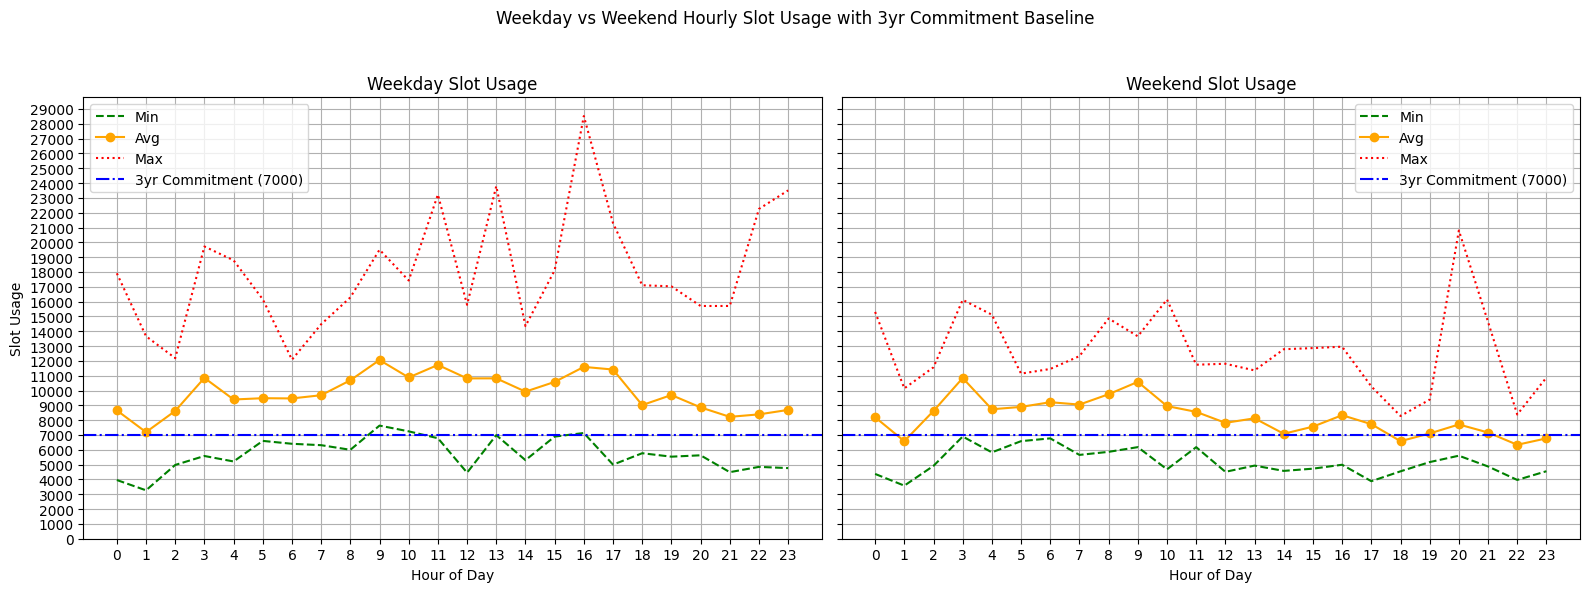

In [18]:
#@title **Visualization V - Weekday vs Weekend Peak & Vally **
#@markdown 👈 **Click this Play button** to start.
#@markdown

import pandas as pd
import matplotlib.pyplot as plt

agg_df = df.groupby(['is_weekend', 'hour']).agg(
    min_slot=('total_slot_hr', 'min'),
    max_slot=('total_slot_hr', 'max'),
    avg_slot=('total_slot_hr', 'mean'),
    median_slot=('total_slot_hr', 'median')
).reset_index()

weekday_stats = agg_df[agg_df['is_weekend'] == False]
weekend_stats = agg_df[agg_df['is_weekend'] == True]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)

baseline = 7000

x_ticks = list(range(0, 24))
y_ticks = list(range(0, int(max(weekday_stats['max_slot'].max(), weekend_stats['max_slot'].max())) + 1000, 1000))

# Weekday
axes[0].plot(weekday_stats['hour'], weekday_stats['min_slot'], label='Min', linestyle='--', color='green')
axes[0].plot(weekday_stats['hour'], weekday_stats['avg_slot'], label='Avg', marker='o', color='orange')
axes[0].plot(weekday_stats['hour'], weekday_stats['max_slot'], label='Max', linestyle=':', color='red')
axes[0].axhline(y=baseline, color='blue', linestyle='-.', label='3yr Commitment (7000)')
axes[0].set_title('Weekday Slot Usage')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Slot Usage')
axes[0].set_xticks(x_ticks)
axes[0].set_yticks(y_ticks)
axes[0].grid(True)
axes[0].legend()

# Weekend
axes[1].plot(weekend_stats['hour'], weekend_stats['min_slot'], label='Min', linestyle='--', color='green')
axes[1].plot(weekend_stats['hour'], weekend_stats['avg_slot'], label='Avg', marker='o', color='orange')
axes[1].plot(weekend_stats['hour'], weekend_stats['max_slot'], label='Max', linestyle=':', color='red')
axes[1].axhline(y=baseline, color='blue', linestyle='-.', label='3yr Commitment (7000)')
axes[1].set_title('Weekend Slot Usage')
axes[1].set_xlabel('Hour of Day')
axes[1].set_xticks(x_ticks)
axes[1].set_yticks(y_ticks)
axes[1].grid(True)
axes[1].legend()

plt.suptitle('Weekday vs Weekend Hourly Slot Usage with 3yr Commitment Baseline')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

